# Dimensionality Reduction

Many Machine Learning problems involve thousands or even millions of features for
each training instance. Not only does this make training extremely slow, it can also make it much harder to find a good solution

Fortunately, in real-world problems, it is often possible to reduce the number of features considerably, turning an intractable problem into a tractable one.

Reducing dimensionality does lose some information (just like compressing an image to JPEG can degrade its quality), so even though it will speed up training, it may also make your system perform slightly worse.

Apart from speeding up training, dimensionality reduction is also extremely useful
for data visualization

## Main Approaches for Dimensionality Reduction

### Projection

In most real-world problems, training instances are not spread out uniformly across
all dimensions. Many features are almost constant, while others are highly correlated. As a result, all training instances actually lie within (or close to) a much lower-dimensional subspace of the high-dimensional space

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [2]:
import sklearn

import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

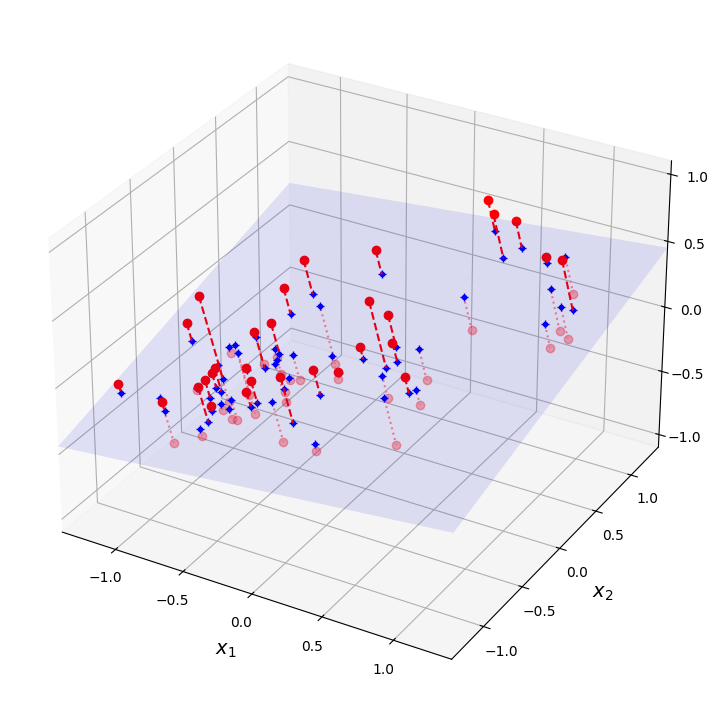

In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # dataset reduced to 2D
X3D_inv = pca.inverse_transform(X2D)  # 3D position of the projected samples
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # projection plane coefs
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # plane
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # samples above plane
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # samples below plane

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection="3d")

# plot samples and projection lines below plane first
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # projection plane
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  # projected samples
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# now plot projection lines and samples above plane
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1])

plt.show()

Notice that all training instances lie close to a plane: this is a lower-dimensional (2D) subspace of the high-dimensional (3D) space. Now if we project every training instance perpendicularly onto this subspace we get the new 2D dataset

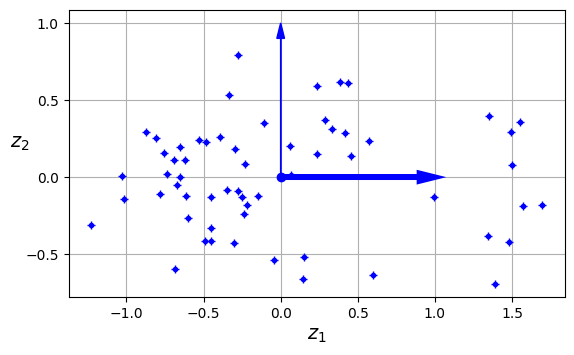

In [4]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.plot(X2D[:, 0], X2D[:, 1], "b+")
ax.plot(X2D[:, 0], X2D[:, 1], "b.")
ax.plot([0], [0], "bo")
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=4)
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=1)
ax.set_xlabel("$z_1$")
ax.set_yticks([-0.5, 0, 0.5, 1])
ax.set_ylabel("$z_2$", rotation=0)
ax.set_axisbelow(True)
ax.grid(True)

However, projection is not always the best approach to dimensionality reduction. In
many cases the subspace may twist and turn

In [5]:
from sklearn.datasets import make_swiss_roll

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

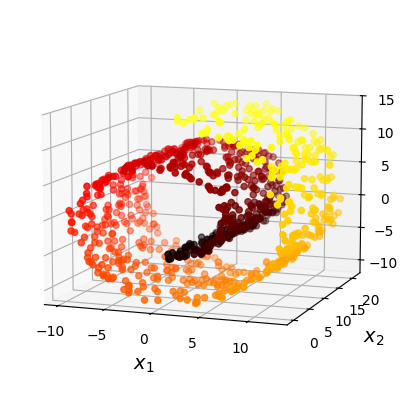

In [6]:
from matplotlib.colors import ListedColormap

darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t, cmap=darker_hot)
ax.view_init(10, -70)
set_xyz_axes(ax, axes)

plt.show()

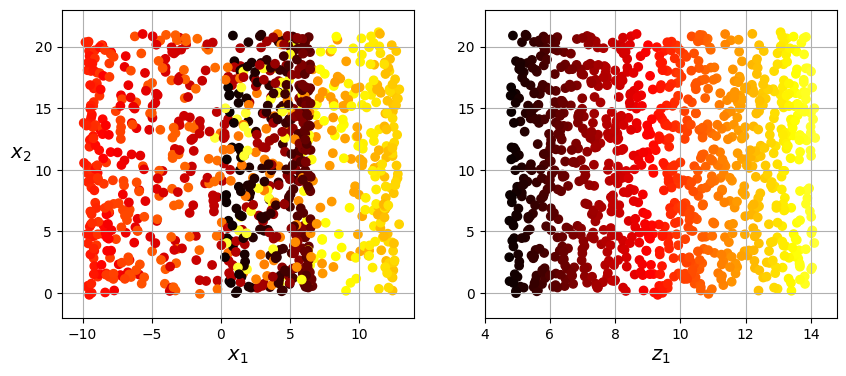

In [7]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.scatter(X_swiss[:, 0], X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", labelpad=10, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis([4, 14.8, axes[2], axes[3]])
plt.xlabel("$z_1$")
plt.grid(True)

plt.show()

Simply projecting onto a plane (e.g., by dropping x3) would squash different layers of the Swiss roll together, as shown on the left. However, what you really
want is to unroll the Swiss roll to obtain the 2D dataset on the right

### Manifold Learning

Manifold Learning attempts to discover the underlying structure of high-dimensional data, assuming that this data actually lives on a lower-dimensional manifold.

The Swiss roll is an example of a 2D manifold. Put simply, a 2D manifold is a 2D
shape that can be bent and twisted in a higher-dimensional space

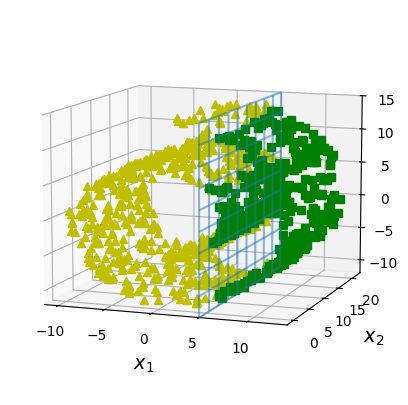

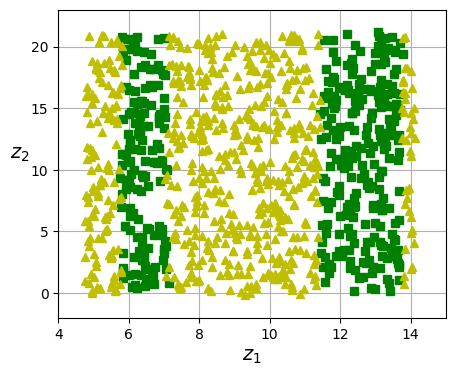

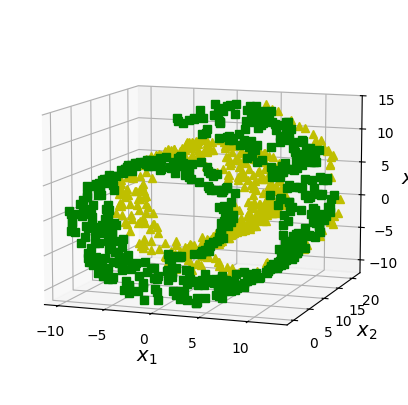

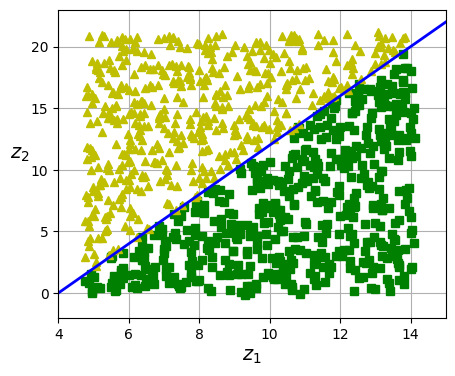

In [8]:
axes = [-11.5, 14, -2, 23, -12, 15]
x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

positive_class = X_swiss[:, 0] > 5
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
set_xyz_axes(ax, axes)

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax.grid(True)

plt.show()

positive_class = 2 * (t[:] - 4) > X_swiss[:, 1]
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel("$x_1$", rotation=0)
ax.set_ylabel("$x_2$", rotation=0)
ax.set_zlabel("$x_3$", rotation=0)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax.plot([4, 15], [0, 22], "b-", linewidth=2)
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax.grid(True)

plt.show()

The manifold assumption is often accompanied by another implicit assumption: that
the task at hand (e.g., classification or regression) will be simpler if expressed in the lower-dimensional space of the manifold.

In short, if you reduce the dimensionality of your training set before training a
model, it will usually speed up training, but it may not always lead to a better or simpler solution; it all depends on the dataset.
